# Geostatistics Athens Week project

Authors: Francesco Sarra, Meiqi Liu, Federica Biffi

General recommendations: 

In this project you will implement and compare the prediction performances of a number of methods. Please provide their comparison in terms of MSE on a unique (or an ensemble of) validation set(s) (A table summarizing your results at the end would be great). For each method please provide a prediction map over the grid as well as a standard deviation map (if possible). Justify carefully your modeling choices, comment and interpret your results.

Your notebook, named after the names of the team members, will have to be uploaded here by the night of sunday 24: 

https://cloud.minesparis.psl.eu/index.php/s/K5PEdwY5l3FBC4c

Good Luck!

## The Jura data set
The Jura data set comprises seven heavy metals measured in the top soil of the swiss Jura, along with consistently coded land use and rock type factors, as well as geographic coordinates. 

Variable description :

* Xloc: X coordinate, local grid km
* Yloc: Y coordinate, local grid km
* Landuse: Land use: 1: Forest, 2: Pasture (Weide(land), Wiese, Grasland), 3: Meadow (Wiese, Flur, Matte, Anger), 4: Tillage (Ackerland, bestelltes Land)
* Rock: Rock Types: 1: Argovian, 2: Kimmeridgian, 3: Sequanian, 4: Portlandian, 5: Quaternary.
* Cd: mg cadmium kg^-1 topsoil
* Co: mg cobalt kg^-1 topsoil
* Cr: mg chromium kg^-1 topsoil
* Cu: mg copper kg^-1 topsoil
* Ni: mg nickel kg^-1 topsoil
* Pb: mg lead kg^-1 topsoil
* Zn: mg zinc kg^-1 topsoil

You are given three different files:

* jura_pred.csv: learning dataset
* jura_grid.csv: prediction grid (contains locations and covariables)
* jura_val_loc: validation locations and covariables

In [134]:
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
import scipy as sc 
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('future.no_silent_downcasting', True)

## I. Exploratory analysis

### Basic statistics
1. load the dataset from jura_pred.csv (on the cloud)
2. What is the class of the dataset?
3. What is the number of observations? What is the number of variables?
4. Print the name of the variables.
5. Compute the minimum and maximum value for each coordinate.
6. Compute basic statistics for the seven different heavy metals (mean, min, max, quartiles and standard deviation)
7. Compute the mean of cobalt concentration for the four different landuses 

In [135]:
#1 Loading jura_pred dataset
jura_all=pd.read_csv("jura/jura_pred.csv")

In [136]:
## Replace landuse interger code by name
landuse_codes=[1,2,3,4]
landuse_names=["Forest","Pasture","Meadow","Tillage"]
jura_all["Landuse"]=jura_all["Landuse"].replace(landuse_codes,landuse_names)

## Replace rock type interger code by name
rock_codes=[1,2,3,4,5]
rock_names=["Argovian","Kimmeridgian","Sequanian","Portlandian","Quaternary"]
jura_all["Rock"]=jura_all["Rock"].replace(rock_codes,rock_names)

In [ ]:
#2 Class of dataset = all variables are float except for Landuse and Rock that are integer. Dataset class: 'pandas.core.frame.DataFrame'
print(jura_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Xloc     259 non-null    float64
 1   Yloc     259 non-null    float64
 2   Landuse  259 non-null    object 
 3   Rock     259 non-null    object 
 4   Cd       259 non-null    float64
 5   Co       259 non-null    float64
 6   Cr       259 non-null    float64
 7   Cu       259 non-null    float64
 8   Ni       259 non-null    float64
 9   Pb       259 non-null    float64
 10  Zn       259 non-null    float64
dtypes: float64(9), object(2)
memory usage: 22.4+ KB
None


In [ ]:
#3 N° observations; N° variables
n_obs = jura_all.shape 
n_obs #259 observations; 11 variables
print("The number of observations is: ", n_obs[0])
print("The number of variables is: ", n_obs[1])

The number of observations is:  259
The number of variables is:  11


In [ ]:
#4 Print the name of variables
print("The names of variables are:", jura_all.columns[:].tolist())

The names of variables are: ['Xloc', 'Yloc', 'Landuse', 'Rock', 'Cd', 'Co', 'Cr', 'Cu', 'Ni', 'Pb', 'Zn']


In [ ]:
#5 max/min of each coordinate
min_x = jura_all['Xloc'].min() 
max_x = jura_all['Xloc'].max()
min_y = jura_all['Yloc'].min() 
max_y = jura_all['Yloc'].max() 
print("The maximum for Xloc is: ", max_x)
print("The minimum for Xloc is: ", min_x)
print("The maximum for Yloc is: ", max_y)
print("The minimum for Yloc is: ", min_y)

The maximum for Xloc is:  4.92
The minimum for Xloc is:  0.626
The maximum for Yloc is:  5.69
The minimum for Yloc is:  0.58


In [ ]:
#6 Basic statistics for heavy metals
stat = jura_all.iloc[:,4:].describe()
print("Statistics of the seven heavy metals:")
print(stat)

Statistics of the seven heavy metals:
               Cd          Co          Cr          Cu          Ni          Pb  \
count  259.000000  259.000000  259.000000  259.000000  259.000000  259.000000   
mean     1.309077    9.302579   35.070116   23.727490   19.730347   53.916602   
std      0.915188    3.576046   10.957509   20.712635    8.232858   29.792158   
min      0.135000    1.552000    8.720000    3.960000    4.200000   18.960000   
25%      0.637500    6.520000   27.440000   11.020000   13.800000   36.520000   
50%      1.070000    9.760000   34.840000   17.600000   20.560000   46.400000   
75%      1.715000   11.980000   42.220000   27.820000   25.420000   60.400000   
max      5.129000   17.720000   67.600000  166.400000   53.200000  229.560000   

               Zn  
count  259.000000  
mean    75.078301  
std     29.019291  
min     25.200000  
25%     55.000000  
50%     73.560000  
75%     89.920000  
max    219.320000  


In [ ]:
#7 Mean of the cobalt concentrations for the different landuses
mean_Co_1=jura_all['Co'][jura_all['Landuse']=="Forest"].mean()
mean_Co_2=jura_all['Co'][jura_all['Landuse']=="Pasture"].mean()
mean_Co_3=jura_all['Co'][jura_all['Landuse']=="Meadow"].mean()
mean_Co_4=jura_all['Co'][jura_all['Landuse']=="Tillage"].mean()
print("The mean for the Forest is: ", mean_Co_1)
print("The mean for the Pasture is: ", mean_Co_2)
print("The mean for the Meadow is: ", mean_Co_3)
print("The mean for the Tillage is: ", mean_Co_4)

The mean for the Forest is:  7.694545454545455
The mean for the Pasture is:  10.064285714285713
The mean for the Meadow is:  9.393866666666666
The mean for the Tillage is:  8.372000000000002


### Graphical Representations
1. Plot the points in the dataset using their coordinates 'Xloc' and 'Yloc'.
2. On the same plot, display the points with landuse 2 (pasture) in red.
3. Plot the seven heavy metal concentrations histograms.
4. Plot the seven heavy metal concentrations as functions of the landuse (boxplots)
5. Plot the seven heavy metal concentrations as functions of the rocktype (boxplots)

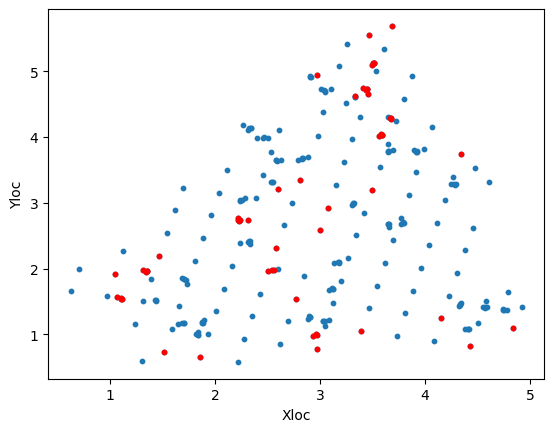

In [ ]:
#1-2 Plot the points in the dataset using their coordinates 'Xloc' and 'Yloc' 
# and on the same plot, display the points with landuse 2 (pasture) in red.
plt.scatter(jura_all['Xloc'],jura_all['Yloc'], s=10)
plt.scatter(jura_all['Xloc'][jura_all['Landuse']=="Pasture"],
            jura_all['Yloc'][jura_all['Landuse']=="Pasture"],color="red", s=10)
plt.xlabel('Xloc')
plt.ylabel('Yloc')
plt.show()

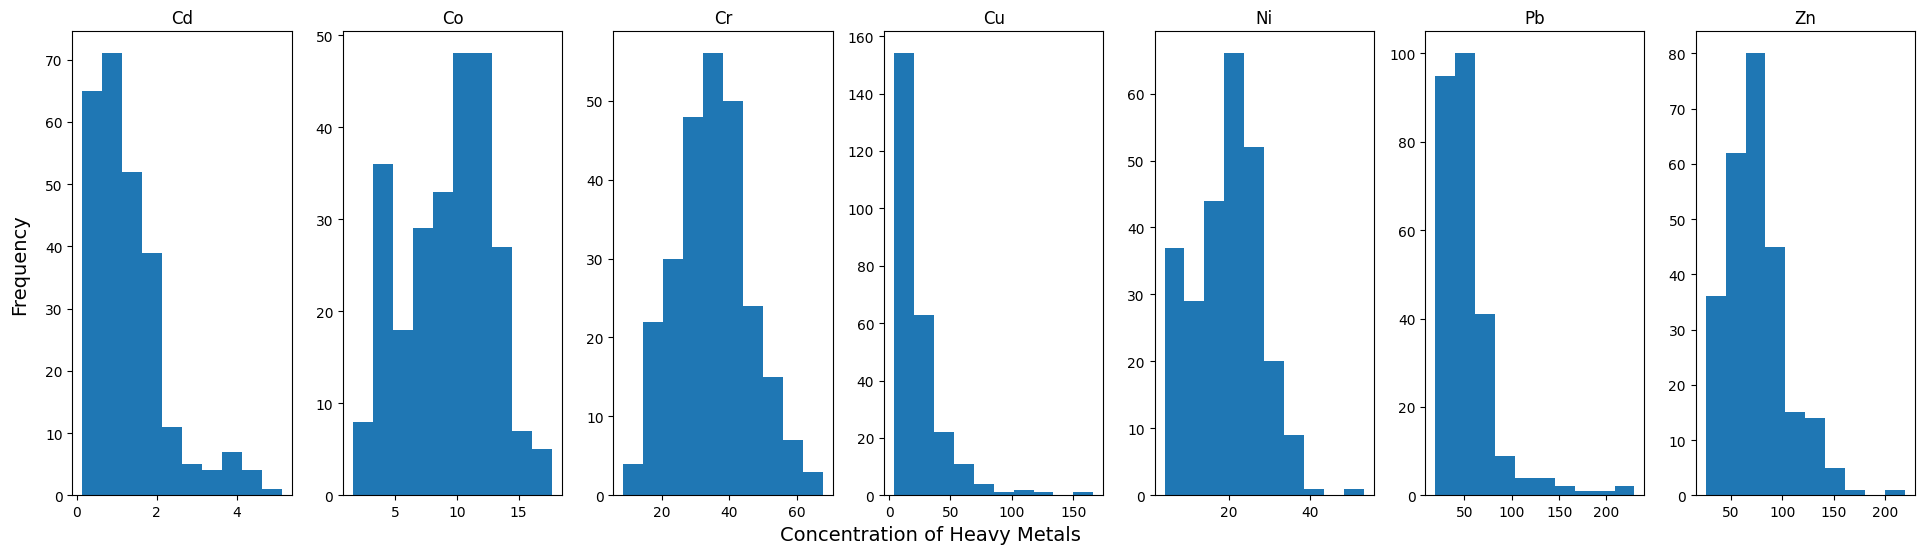

In [ ]:
#3 Plot the seven heavy metal concentrations histograms.
metal_names = jura_all.columns.values[4:]
fig,ax = plt.subplots(nrows=1,ncols=len(metal_names),figsize=(20,6))
for i in range(len(metal_names)):
    name=metal_names[i]
    ax[i].hist(jura_all[name]) 
    ax[i].set_title(name)

# Add a single x-axis and y-axis label for the whole figure
fig.text(0.5, 0.04, 'Concentration of Heavy Metals', ha='center', fontsize=14)  # Y-axis title
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # X-axis title

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to prevent overlap with axis labels

plt.show()

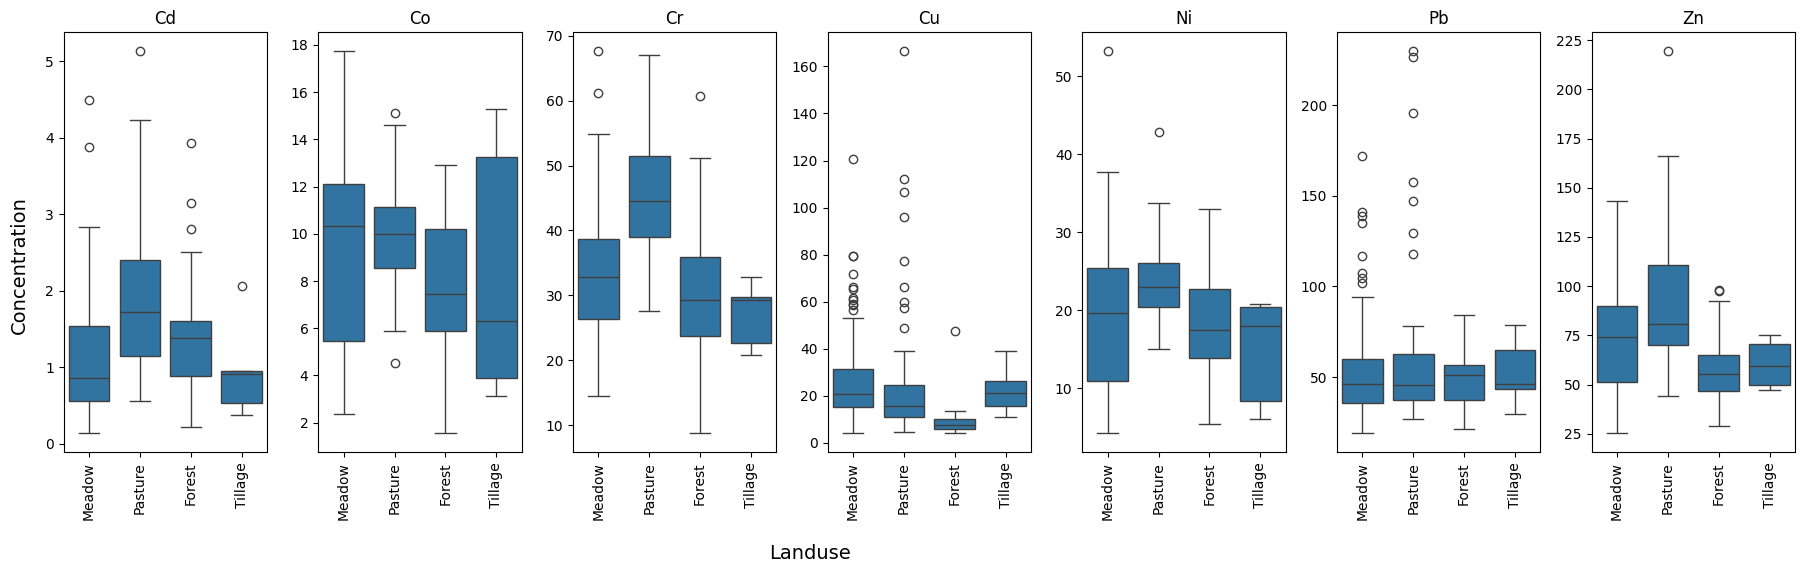

In [ ]:
#4 Plot the seven heavy metal concentrations as functions of the landuse (boxplots)
metal_names = jura_all.columns.values[4:]
fig, ax = plt.subplots(nrows=1, ncols=len(metal_names), figsize=(20, 6))  # To create a grid of plots

for i, name in enumerate(metal_names):
    # Create boxplots with custom colors for Landuse groups
    sns.boxplot(x=jura_all['Landuse'], y=jura_all[name], ax=ax[i])
    ax[i].set_title(name)  # Set title for each metal
    ax[i].set_ylabel("")   # Remove individual y-axis titles
    ax[i].set_xlabel("")   # Remove individual x-axis titles
    ax[i].tick_params(axis='x', rotation=90)

# Add a single y-axis label for the entire figure
fig.text(0.1, 0.5, 'Concentration', va='center', rotation='vertical', fontsize=14)
# Add a single x-axis label for the entire figure
fig.text(0.5, 0.01, 'Landuse', ha='center', fontsize=14)

plt.tight_layout(rect=[0.11, 0.05, 1, 0.95])

plt.show()

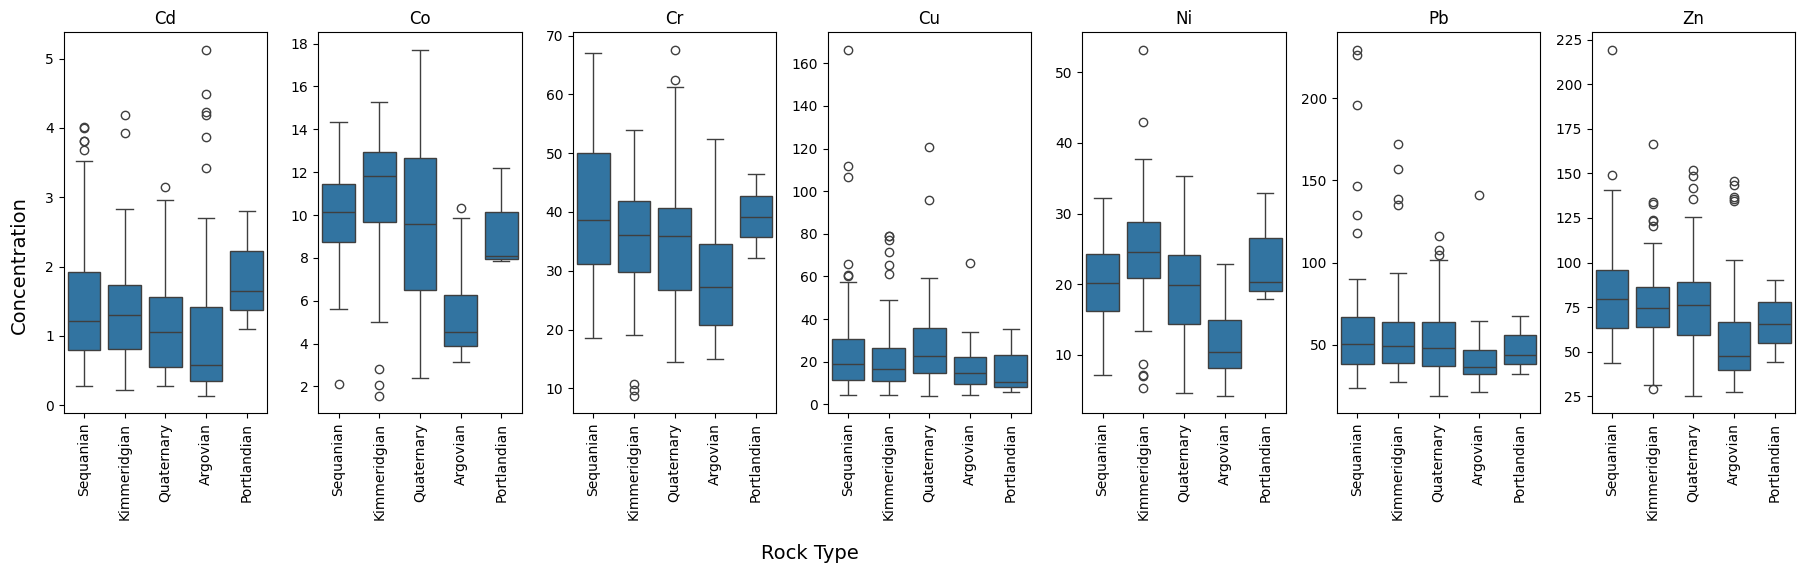

In [ ]:
#5 Plot the seven heavy metal concentrations as functions of the rocktype (boxplots)
metal_names = jura_all.columns.values[4:]
fig, ax = plt.subplots(nrows=1, ncols=len(metal_names), figsize=(20, 6))  # To create a grid of plots

for i, name in enumerate(metal_names):
    # Create boxplots with custom colors for Landuse groups
    sns.boxplot(x=jura_all['Rock'], y=jura_all[name], ax=ax[i])
    ax[i].set_title(name)  # Set title for each metal
    ax[i].set_ylabel("")   # Remove individual y-axis titles
    ax[i].set_xlabel("")   # Remove individual x-axis titles
    ax[i].tick_params(axis='x', rotation=90)

# Add a single y-axis label for the entire figure
fig.text(0.1, 0.5, 'Concentration', va='center', rotation='vertical', fontsize=14)
# Add a single x-axis label for the entire figure
fig.text(0.5, 0.01, 'Rock Type', ha='center', fontsize=14)

plt.tight_layout(rect=[0.11, 0.05, 1, 0.95])

plt.show()

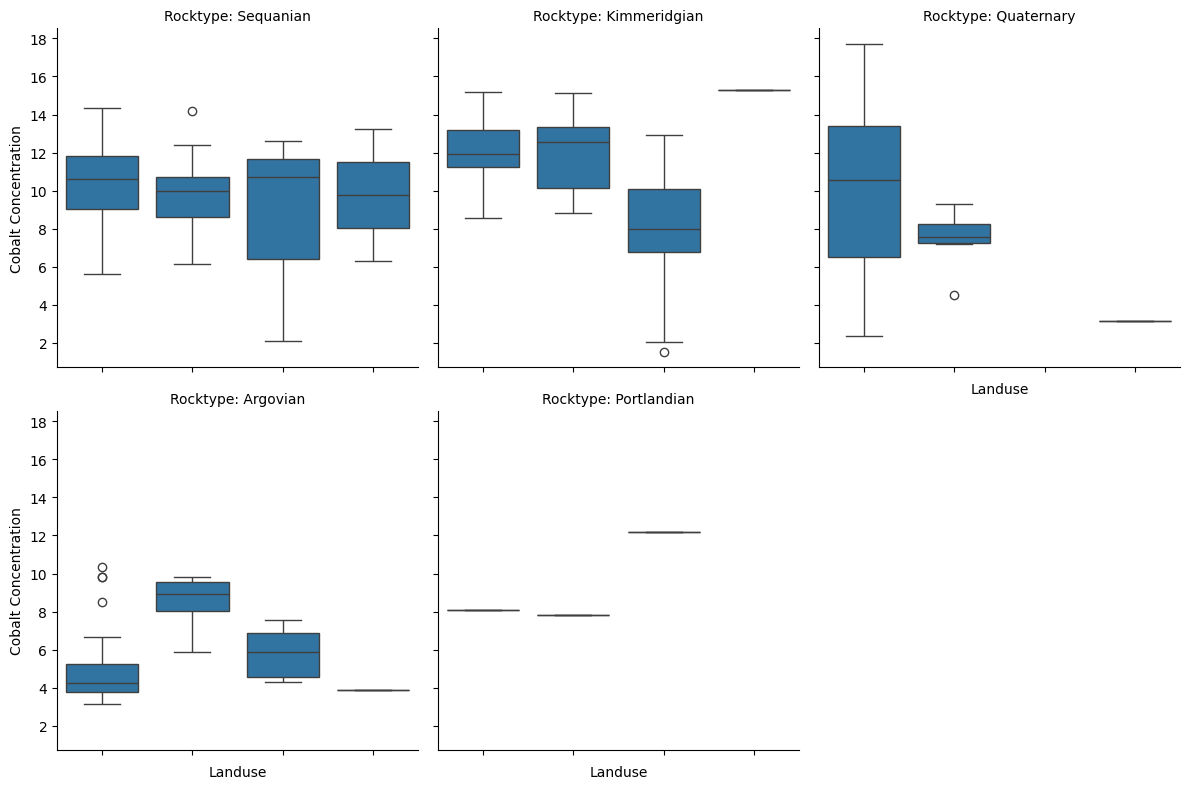

In [ ]:
# Plot showing the interaction between landuse and rocktype
# Create a FacetGrid
# Ensure 'Landuse' is a categorical column with the correct order
fig = sns.FacetGrid(jura_all, col="Rock", col_wrap=3, height=4, sharey=True)
fig.map(sns.boxplot, "Landuse", "Co", order=["Meadow", "Pasture", "Forest", "Tillage"])

# Adjust plot labels
fig.set_axis_labels("Landuse", "Cobalt Concentration")
fig.set_titles(col_template="Rocktype: {col_name}")
fig.set_xticklabels(rotation=90)  # Rotate x-axis labels
fig.tight_layout()

plt.show()

### Some statistics
1. Cobalt concentrations with Landuse, Rock and the interactions. Comment the results.
2. Do the same on the other concentrations (check the histograms prior to apply a transformation if necessary).

#### Answers
- Overall, from the histogram we can see that most observations on Co has a concentration between 5 and 10.
- Landuse has an impact on the Cobalt concentrations:
  - Tillage has the lowest median concentrations, while Meadow has the highest median concentrations.
  - The median concentrations increase from landuse Tillage < Forst < Pasture < Meadow
  - Tillage has the highest variance on Cobalt concentration distribution.
  - Pasture has the smallest variance on Cobalt concentrations.
- Rock type also has impact on the Cobalt concentrations:
  - Argovian type has the lowest median concentrations, while Kimmeridgian type has the highest median concentrations.
  - The median concentrations increase from Argovian < Portlandian < Quaternary < Sequanian < Kimeridgian
- For the interactions between rock and landuse:
  - For Sequanian, Co concentrations show moderate variability.
  - For Kimmeridgian, Forest has significant lower Co concentrations compared to Meadow and Pasture.
  - For Quatenary, there are large difference. Meadow has the highest variability and median concentration.
  - For Argovian, Pasture has higher median concentration compared to Forest, then Meadow.
- For other heavy metals, the variations among different landuse and rock type different.
  - Generally, Pasture landuse has the highest concentrations for most metals.
  - Generally, rock type Portlandian and Kimmeridgian have the highest concentrations for most metals.

## II. Interpolation

Provide the maps of the cobalt concentration over the Swiss Jura obtained with several regression/interpolation methods, e.g.:


* anova
* linear regression on the coordinates
* Random Forests
* Nearest neighbours
* Inverse distance
* ...


### 2.1 ANOVA
Load the prediction grid and validation dataset (?).

In [137]:
# Load Prediction grid
grid = pd.read_csv("jura/jura_grid.csv")

Split the jura dataset into training and validation set.

In [ ]:
np.random.seed(0)
ntot = jura_all.shape[0]
ntrain = 200
nval = ntot - ntrain

indtrain = np.random.choice(ntot,ntrain, replace= False).astype(int)
indval = np.setdiff1d(np.arange(ntot),indtrain)

jura =jura_all.loc[indtrain,:]

val_loc =jura_all.loc[indval,['Xloc','Yloc','Landuse','Rock']]
val=jura_all.loc[indval,['Co']]

In [140]:
# change the name of landuse and rock for validation set
val_loc["Landuse"]=val_loc["Landuse"].replace(landuse_codes,landuse_names)
val_loc["Rock"]=val_loc["Rock"].replace(rock_codes,rock_names)

Setup gstlearn utilities for display

In [142]:
### Load grid data into  point database
db_grid_pts=gl.Db_fromPanda(grid)
db_grid_pts.setLocators(["Xloc","Yloc"],gl.ELoc.X)
db_grid_pts["Landuse"]=grid["Landuse"].replace(landuse_names,landuse_codes) ## String names are not supported
db_grid_pts["Rock"]=grid["Rock"].replace(rock_names,rock_codes)## String names are not supported

### Create empty grid database with right dimensions
xgrid=np.unique(db_grid_pts["Xloc"])
ygrid=np.unique(db_grid_pts["Yloc"])
db_grid=gl.DbGrid.create(nx=[len(xgrid),len(ygrid)],
                         dx=[xgrid[1]-xgrid[0],ygrid[1]-ygrid[0]],
                         x0=[xgrid[0],ygrid[0]])

### Migrate variables from point database to grid database
err=gl.migrateMulti(db_grid_pts,db_grid,
                    names=["Landuse","Rock"],
                    namconv=gl.NamingConvention())

### Add selection 
db_grid.addSelection(~np.isnan(db_grid["Landuse"]))

## Function to add a variable to a grid database
def add_variable(var,db_pts_in,db_grid_out,name):
  db_pts_copy=gl.Db(db_pts_in)
  db_pts_copy[name]=var ## Add variable
  
  db_grid_out_copy=gl.DbGrid(db_grid_out)
  err=gl.migrateMulti(db_pts_copy,db_grid_out_copy,
                    names=[name],
                    namconv=gl.NamingConvention())
  
  return db_grid_out_copy


### Display content
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 11349
Number of active samples     = 5957

Grid characteristics:
---------------------
Origin :      0.300     0.100
Mesh   :      0.050     0.050
Number :         97       117

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Landuse - Locator = z1
Column = 4 - Name = Rock - Locator = z2
Column = 5 - Name = NewSel - Locator = sel


Perform a linear regression and ANOVA analysis with categorical variables.

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.api import stats
# Fit the regression model
model_aov = ols(formula='Co ~  Landuse + Rock + Landuse * Rock', data=jura).fit()
# Perform anova analysis
anova_table = stats.anova_lm(model_aov)
# Prediction on the grid
res_aov=model_aov.predict(grid)
print(anova_table)

                 df       sum_sq     mean_sq          F        PR(>F)
Landuse         3.0    74.562844   24.854281   3.565004  1.529697e-02
Rock            4.0   932.571454  233.142863  33.441125  6.237449e-21
Landuse:Rock   12.0   258.913445   21.576120   3.094797  5.196070e-04
Residual      183.0  1275.828617    6.971741        NaN           NaN


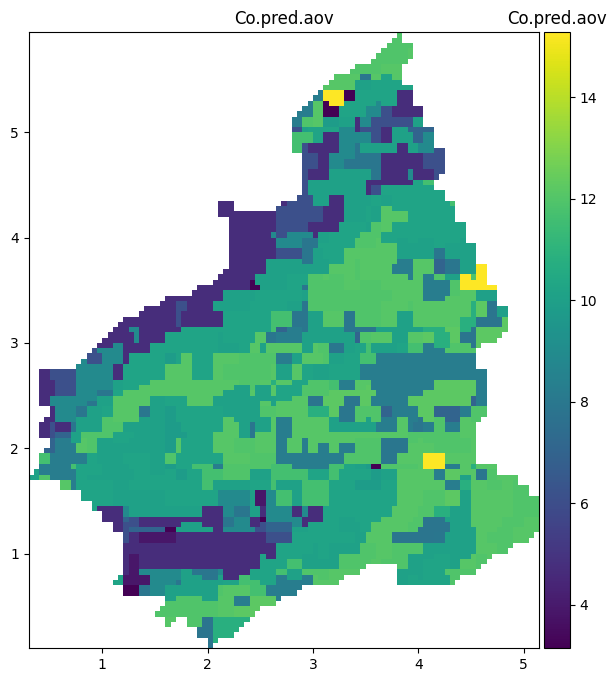

In [ ]:
## Plot results
res_name="Co.pred.aov"
grid_plt=add_variable(res_aov,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [ ]:
#Prediction on the validation locations
res_aov_val=model_aov.predict(val_loc)

In [ ]:
#Compute score 
print("MSE for ANOVA: ",np.mean((res_aov_val-val['Co'])**2))

MSE for ANOVA:  8.576441758361346


### 2.2 Nearest neighbours
We use the *KNeighborsRegressor* function from the *sklear.neighbors* package.
We tried several values of neighbors, and set 2 as the best.

Maybe add a for loop to automatically choose the best setup

In [ ]:
## k-Nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
## Fit model
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(jura[['Xloc','Yloc']], jura['Co'])

KNeighborsRegressor(n_neighbors=2)

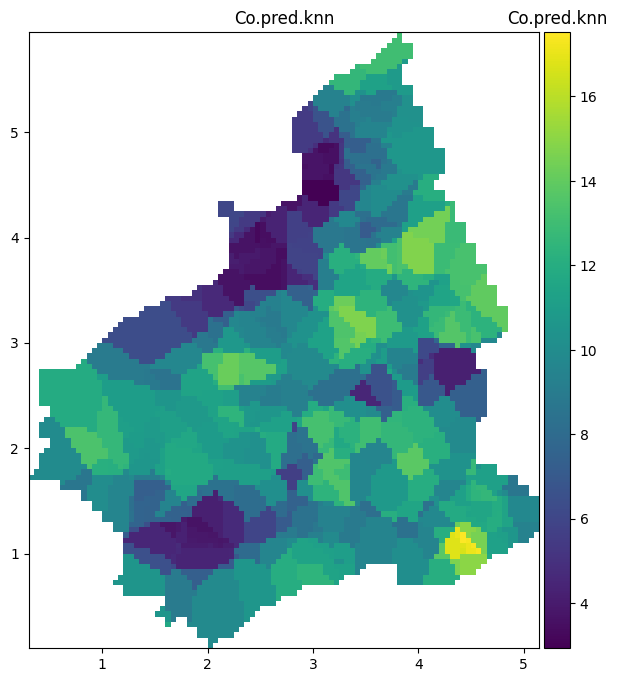

In [ ]:
## Prediction on the grid
res_knn=model_knn.predict(grid[['Xloc','Yloc']])

## Plot results
res_name="Co.pred.knn"
grid_plt=add_variable(res_knn,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [ ]:
## Prediction on the validation locations
res_val_knn=model_knn.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE for the 2-Nearest Neighbors: ",np.mean((res_val_knn-val['Co'])**2))

MSE for the 2-Nearest Neighbors:  5.268373355932204


### 2.3 Inverse distance
We use the *RadiusNeighborsRegressor* function from the *scikit-learn* package.

We choose a radius distance of 3.

maybe add a for loop to choose automatically.

In [ ]:
from sklearn.neighbors import RadiusNeighborsRegressor
## Fit model
model_invdist = RadiusNeighborsRegressor(radius=3,weights='distance') 
model_invdist.fit(jura[['Xloc','Yloc']], jura['Co'])

RadiusNeighborsRegressor(radius=3, weights='distance')

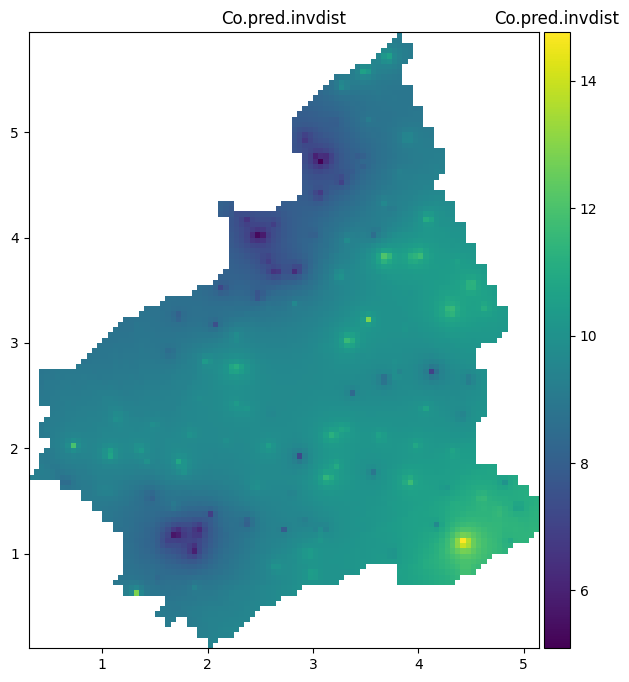

In [28]:
## Prediction on the grid
res_invdist=model_invdist.predict(grid[['Xloc','Yloc']])

## Plot results
res_name="Co.pred.invdist"
grid_plt=add_variable(res_invdist,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [29]:
## Prediction on the validation locations
res_val_invdist=model_invdist.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE for inverse distance with 3: ",np.mean((res_val_invdist-val['Co'])**2))

MSE for inverse distance with 3:  6.177549013566917


### 2.4 Random Forest
We setup the random forst with 200 estimator and maximum depth of 15.

In [30]:
## Random forest
from sklearn.ensemble import RandomForestRegressor

## Fit model
model_rf = RandomForestRegressor(n_estimators=200,max_depth=15)
model_rf.fit(jura[['Xloc','Yloc']], jura['Co'])

## Prediction on the grid
res_rf=model_rf.predict(grid[['Xloc','Yloc']])

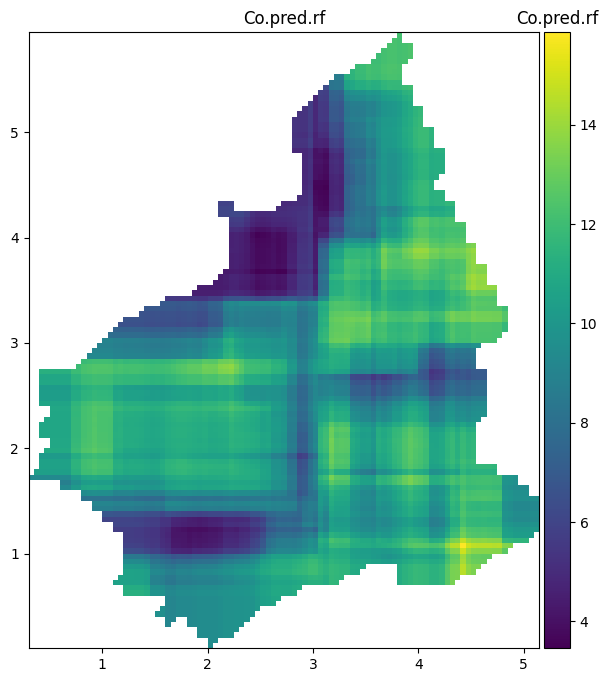

In [31]:
## Plot results
res_name="Co.pred.rf"
grid_plt=add_variable(res_rf,db_grid_pts,db_grid,res_name)
fig,ax = gp.initGeographic()
ax.raster(grid_plt,name=res_name, flagLegend=True)
fig.show()

In [32]:
## Prediction on the validation locations
res_val_rf=model_rf.predict(val_loc[['Xloc','Yloc']])

## Compute score 
print("MSE for Random Forest: ",np.mean((res_val_rf-val['Co'])**2))

MSE for Random Forest:  4.115321683500007


## III. Univariate analysis

### III.1 Variography

#### Experimental variogram (isotropic case)

1. Compute and plot the experimental variogram of the cobalt concentration. Try different values of lag and comment the results. 
2. Print the number of pairs of points used to compute the variogram values for different values of lag and comment the results.

We use the *gstlearn* package to construct variogram and make analysis.

In [143]:
## Create databse
db_jura=gl.Db_fromPanda(jura)
## Set locators
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X)
db_jura.setLocators(['Co'],gl.ELoc.Z)

In [144]:
# create experimental variogram
varioParamOmni = gl.VarioParam.createOmniDirection(npas=15, dpas=0.1, toldis=0.5)
## Create experimental variogram object with specified parameters
varioexp = gl.Vario(varioParamOmni)
## Compute experimental variogram
err = varioexp.compute(db_jura)
## Display result
varioexp.display()


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variable(s)                 = [Co]

Variance-Covariance Matrix    12.641

Direction #1
------------
Number of lags              = 15
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =      0.100
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0    95.000     0.025     1.748
         1    77.000     0.100     3.444
         2   135.000     0.206     3.890
         3   249.000     0.297     7.508
         4   393.000     0.390     7.254
         5   399.000     0.494     8.791
         6   291.000     0.601     9.363
         7   429.000     0.701    11.012
         8   586.000     0.801    10.915
         9   397.000     0.897    12.555
        10   548.000     

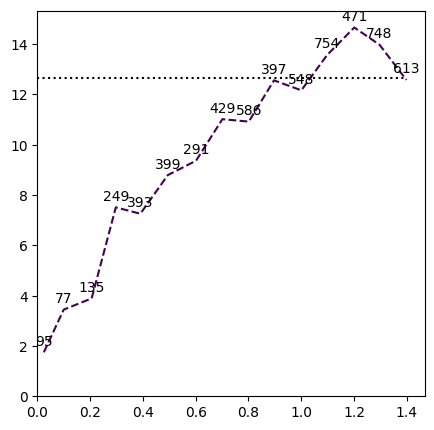

In [145]:
## Plot
ax = gp.varmod(varioexp,showPairs=True)

#### Comments
For Variogram: 
- The results show that lower the lag values, the more distance between points on the variogram.
- Higher values show more information (details) on the variogram, in our case especially when the distance is high (after 0.8).
- But the sill and range remains unaffected.

For Number of Pairs:
- The value remains unaffected while changing the lags.

#### Experimental variogram (anisotropic case)

1. Compute and plot the variogram maps of the Cobalt concentration to check for anisotropies. Comment.
2. Compute and plot directional variograms (according to the anisotropy directions determined with the maps).

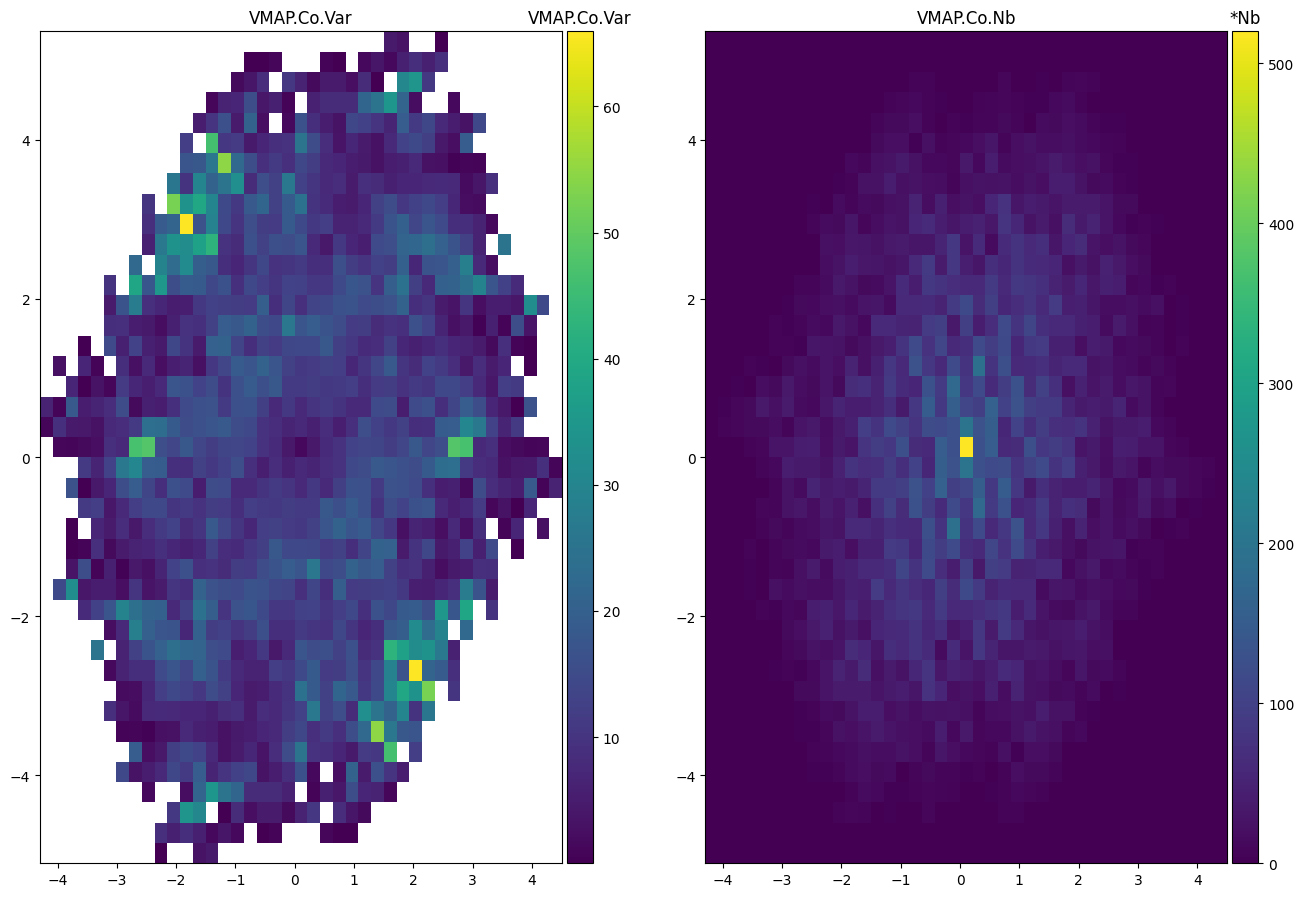

In [36]:
## Compute variogram map
grid_vmap = gl.db_vmap(db_jura)

## Plot (Left: Variogram map, Right: Number of pairs used to compute each value)
fig, ax = plt.subplots(1,2,figsize=[14,10])
fig.tight_layout(pad=5.0)
ax[0].raster(grid_vmap, flagLegend=True)
ax[1].raster(grid_vmap, name="*Nb", flagLegend=True)
plt.show()

#### Comment
The experimenal variogram map shows an anisotropy in the direction of NE-SW.


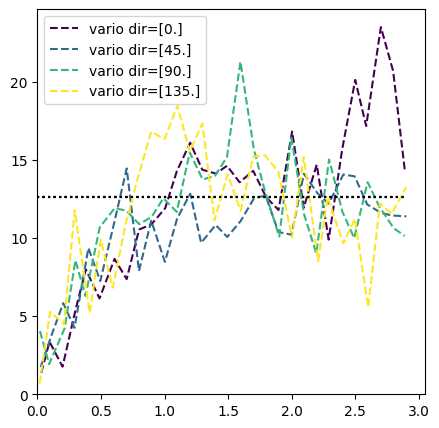

In [146]:
## Create experimental variogram parametrization:
varioParamMulti = gl.VarioParam.createMultiple(ndir=4,npas=30, dpas=0.1, toldis=0.5)

## Initialize experimental variogram object
vario_4dir = gl.Vario(varioParamMulti)
## Compute
err = vario_4dir.compute(db_jura)
## Plot
ax = gp.varmod(vario_4dir, flagLegend=True)

#### Comments
The directional variogram shows that in 4 directions, the distribution of Co concentration has slightly different characeristics, reveals the anisotropic of Co distribution:
- The sill of direction 90 is highest, then 135.
- Also the range for direction 90 and 135 is smaller than the other two directions.

#### Model adjustement

1. Adjust a model (isotropic and anisotropic cases) on experimental variograms and print the model caracteristics.
2. Try imposing different structures or combinations of structures.

In [147]:
## Create Model object
fitmod = gl.Model()
## Fit model on experimental variogram
err = fitmod.fit(varioexp)
## Display result
fitmod.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =     12.449
- Range        =      0.853
Total Sill     =     12.449
Known Mean(s)     0.000


In [148]:
## Fit model on experimental variogram
types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL] 
         #gl.ECov.CUBIC]
err = fitmod.fit(varioexp, types=types)

## Display result
fitmod.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =      1.229
Exponential
- Sill         =     14.837
- Range        =      2.079
- Theo. Range  =      0.694
Total Sill     =     16.066
Known Mean(s)     0.000


#### Comments
Compare with structures on Spherical:
- When we add structures on nugget + exponential + cubic, the sill and range number got higher.
- When we add structures on nugget + Gaussian + cubic, the sill number got lower, but range got higher.

### III.2 Prediction

#### Ordinary Kriging

1. Compute and plot the ordinary kriging of the cobalt over the prediction grid. Plot the associated standard deviation map.
2. Try several variogram models (basic structures, anisotropy), and neighborhood options. Compute the prediction scores. Comment the results.


We create a gstlearn *Database* for validation and grid that containing the target grid for the prediction.

In [149]:
## Create DbGrid that covers the Db containing the data
db_grid=gl.DbGrid.createCoveringDb(db_jura,dx=[0.05,0.05],margin=[0.2,0.2])

## Create Db for validation set
db_val=gl.Db_fromPanda(val_loc)
## Set locators
db_val.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
## Add Co values
db_val["Co"]=val


In [157]:
# specify in the Jura dataset the variable we want to predict
db_jura.setLocators(['Co'],gl.ELoc.Z,cleanSameLocator=True)
## For a unique neighborhood
uniqueNeigh = gl.NeighUnique.create()

# Fit the model
model_OK=gl.Model(fitmod)
## Add constant drift
model_OK.addDrift(gl.DriftM())

## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["OK*"])

## Compute ordinary kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=model_OK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK")
              )

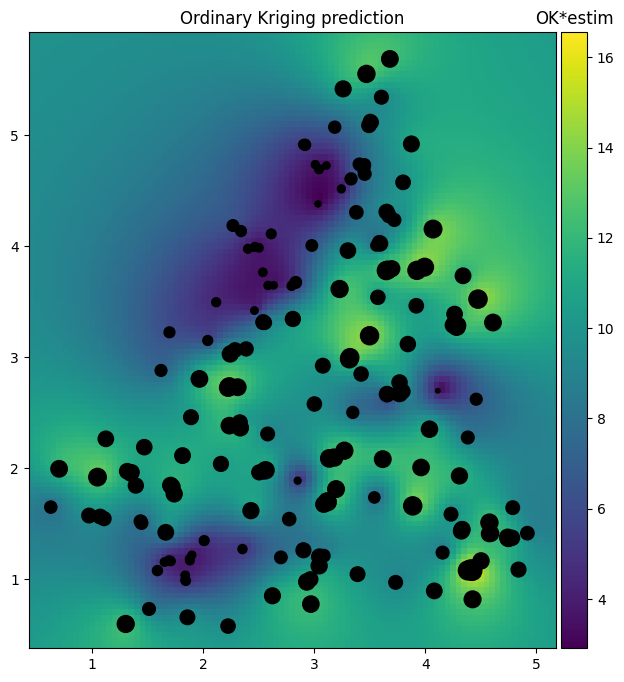

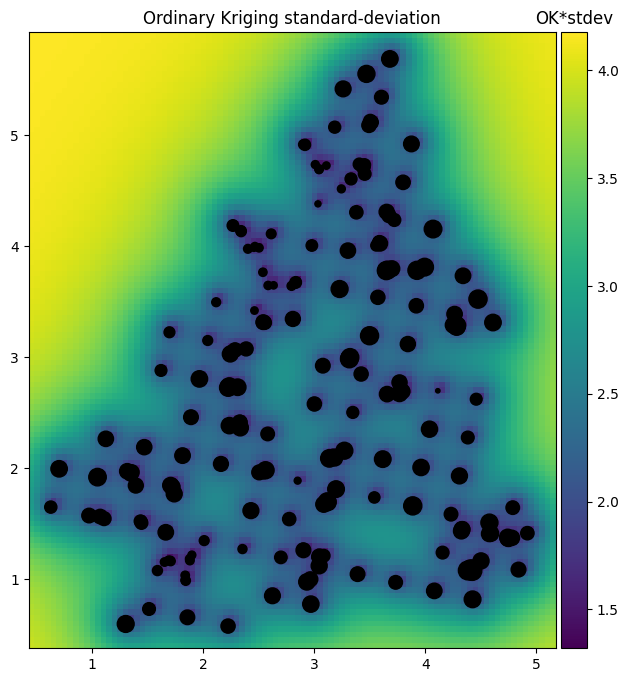

In [158]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="OK*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging prediction")
plt.show()

## Plot kriging standard-deviation
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="OK*stdev",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging standard-deviation")
plt.show()

#### Universal kriging

Use the indicators of the different levels of the categorical variables (*Rock*,*Landuse* and the interactions) as covariates to compute the universal kriging prediction. 

1. Define a model with a constant mean (*order = 0*) and the number of variables with a f locator the we want to work with (*nfex = 4*).
2. Compute the variogram of the residuals.
3. Adjust a model on the variogram of the residuals. Do not forget to set the drift functions.
4. Compute the Kriging with external drift prediction on the grid as well as the standard deviation map.

First, we build the predictor variables corresponding to Rock.

Then we need to update the jura and validation dataset, for purpose for this universal kriging (with categorical factors).

And we repeat the command lines which creat gstlearn database for jura, validation set and grid.

In [159]:
from sklearn.preprocessing import OneHotEncoder
# drop the first column for each feature
enc = OneHotEncoder(handle_unknown='ignore',drop='first')
enc.fit(jura_all[["Rock"]])
rock_indic_jura = pd.DataFrame(enc.transform(jura_all[["Rock"]]).toarray(),
                               columns = ["Rock_K","Rock_P","Rock_Q","Rock_S"])
jura_all = pd.concat([jura_all,rock_indic_jura],axis=1)
rock_indic_grid = pd.DataFrame(enc.transform(grid[["Rock"]]).toarray(),
                               columns = ["Rock_K","Rock_P","Rock_Q","Rock_S"])
grid = pd.concat([grid,rock_indic_grid],axis=1)

In [160]:
jura =jura_all.loc[indtrain,:]

#val contains the values to predict. For the project, these values will be on Kaggle
#(for other locations) and you won't know them
#You will have the locations and covariables at the unknown locations by the following command :
val_loc =jura_all.loc[indval,['Xloc','Yloc',"Rock_K","Rock_P","Rock_Q","Rock_S"]]
val=jura_all.loc[indval,['Co']]

In [161]:
## Create Db
db_jura=gl.Db_fromPanda(jura)

## Set locators
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
db_jura.setLocators(['Co'],gl.ELoc.Z) # -> Role  = Variable of interest
db_jura.setLocators(["Rock*"],gl.ELoc.F) # -> Role = Drift functions

### Load grid data into  point database
db_grid_pts=gl.Db_fromPanda(grid)
db_grid_pts.setLocators(["Xloc","Yloc"],gl.ELoc.X)
db_grid_pts.setLocators(["Rock*"],gl.ELoc.F)

### Create empty grid database with right dimensions
db_grid=gl.DbGrid.createCoveringDb(db_jura,dx=[0.05,0.05],margin=[0.2,0.2])

### Migrate variables from point database to grid database
err=gl.migrateMulti(db_grid_pts,db_grid,
                    names=["Rock_K","Rock_P","Rock_Q","Rock_S"],
                    namconv=gl.NamingConvention())

### Add selection 
db_grid.addSelection(~np.isnan(db_grid["Rock_K"]))
db_grid.setLocators(["Rock*"],gl.ELoc.F)

# Create Db
db_val=gl.Db_fromPanda(val_loc)

## Set locators
db_val.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
db_val.setLocators(["Rock*"],gl.ELoc.F) # -> Role = Drift functions

## Add Co values
db_val["Co"]=val

Next, we define a model with a constant mean (*order = 0*) and the number of variables with a f locator the we want to work with (*nfex = 4*)

Then we compute the variograms of the residuals.

In [162]:
EDmodel = gl.Model()
EDmodel.setDriftIRF(nfex = 4)

# create experimental variogram
varioParamOmni = gl.VarioParam.createOmniDirection(npas=30, dpas=0.1, toldis=0.5)

## Create experimental variogram object with specified parameters
varioRaw = gl.Vario(varioParamOmni) #Raw variable for comparison purpose
varioKED = gl.Vario(varioParamOmni)

## Compute experimental variogram
err = varioRaw.compute(db_jura)
err = varioKED.compute(db_jura,model=EDmodel) #We pass the model to indicate
                                              #that we work on residuals which will
                                              #be computed by the function.

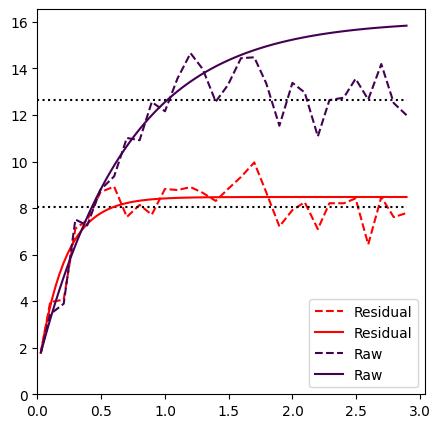

In [163]:
## Create Model objects
fitmodKED = gl.Model()

## set the drift within the model
fitmodKED.setDriftIRF(order = 0, nfex = 4)

## Fit model on experimental variogram
err = fitmodKED.fit(varioKED, types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL])

## Plot
ax = gp.varmod(varioKED, fitmodKED,showPairs=False,color = "r",label = "Residual")
ax = gp.varmod(varioRaw, fitmod,showPairs=False,label = "Raw")
ax = plt.legend()
plt.show()

Next, we compute the Kriging with external drift prediction on the grid as well as the standard deviation map.

In [164]:
## Set the neighborhood
uniqueNeigh = gl.NeighUnique.create()

## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["KED*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=fitmodKED, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("KED") ## Prefix that will be used to identify the results in the output database
              )

## Display database
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 9
Total number of samples      = 10545
Number of active samples     = 5895

Grid characteristics:
---------------------
Origin :      0.426     0.380
Mesh   :      0.050     0.050
Number :         95       111

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = Rock_K - Locator = f1
Column = 3 - Name = Rock_P - Locator = f2
Column = 4 - Name = Rock_Q - Locator = f3
Column = 5 - Name = Rock_S - Locator = f4
Column = 6 - Name = NewSel - Locator = sel
Column = 7 - Name = KED.Co.estim - Locator = z1
Column = 8 - Name = KED.Co.stdev - Locator = NA


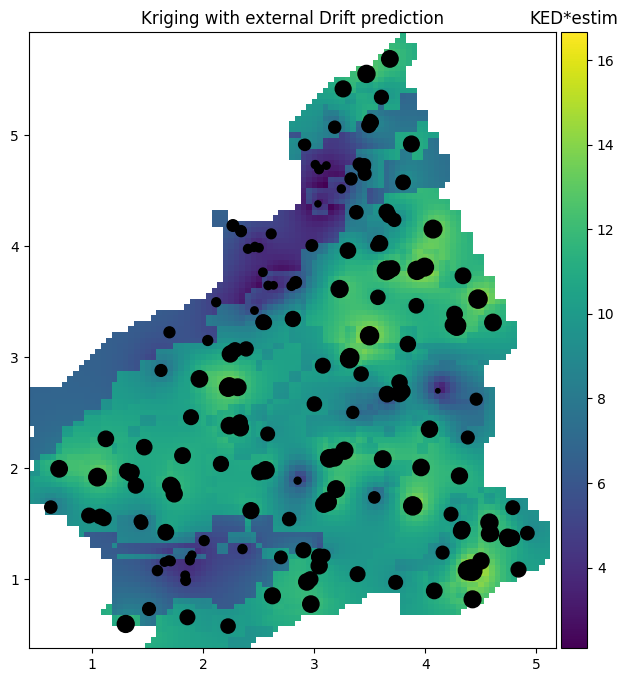

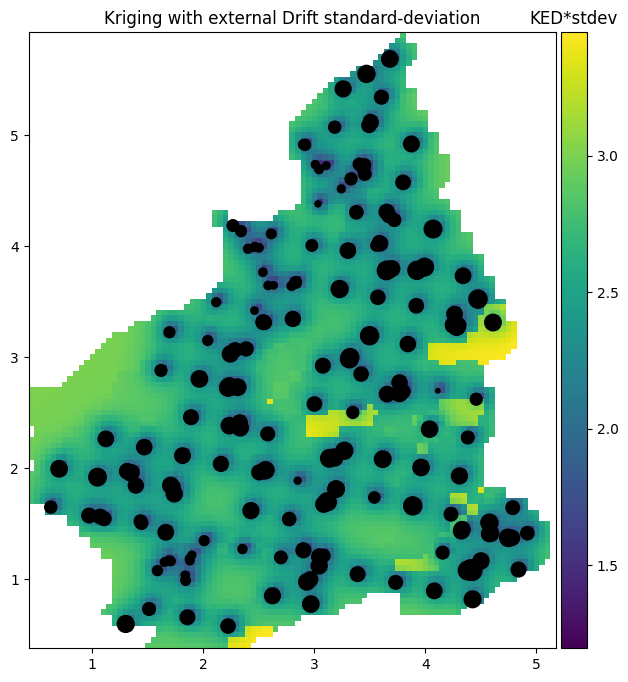

In [165]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="KED*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Kriging with external Drift prediction")
plt.show()

## Plot kriging standard-deviation
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="KED*stdev",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Kriging with external Drift standard-deviation")
plt.show()

In [167]:
# Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["OK*"])
db_val.deleteColumns(["KED*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=fitmodKED, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("KED") ## Prefix that will be used to identify the results in the output database
              )

err = gl.kriging(dbin=db_jura, dbout=db_val, model=model_OK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("OK") ## Prefix that will be used to identify the results in the output database
              )

## Compute RMSE
rmse_KED=np.mean((db_val["Co"]-db_val["KED*estim"])**2)
rmse_OK=np.mean((db_val["Co"]-db_val["OK*estim"])**2)

print("MSE for Ordinary Kriging:",rmse_OK)
print("MSE KED:",rmse_KED)

MSE for Ordinary Kriging: 3.7100285574847214
MSE KED: 3.6433613121254442


## IV. Multivariate analysis

### IV.1 Fitting a multivariate model

1. Compute the  empirical directional variograms and covariograms of a carefully chosen (justify) set of variables.
2. Fit a model

Looking at the boxplot in section I on the variations between different rock types for the heavy metals concentrations, we choose a multivariate modek fit Cobalt (Co) and Nickel (Ni) concentrations.

?? Construct a correlation test between different variables

In [168]:
## Set locators 
db_jura.setLocators(["Co","Ni"],gl.ELoc.Z,cleanSameLocator=True) # -> Role = Variable of interest

## Display content
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 13
Total number of samples      = 200

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Cd - Locator = NA
Column = 3 - Name = Co - Locator = z1
Column = 4 - Name = Cr - Locator = NA
Column = 5 - Name = Cu - Locator = NA
Column = 6 - Name = Ni - Locator = z2
Column = 7 - Name = Pb - Locator = NA
Column = 8 - Name = Zn - Locator = NA
Column = 9 - Name = Rock_K - Locator = f1
Column = 10 - Name = Rock_P - Locator = f2
Column = 11 - Name = Rock_Q - Locator = f3
Column = 12 - Name = Rock_S - Locator = f4


In [169]:
## Create experimental variogram parametrization: 4 directions, 40 lags of size 0.05
varioParamMulti = gl.VarioParam.createMultiple(ndir=4,npas=40, dpas=0.05, toldis=0.5)

## Create experimental variogram object, and compute it from the data
varioexp2var = gl.Vario.create(varioParamMulti)
err = varioexp2var.compute(db_jura)

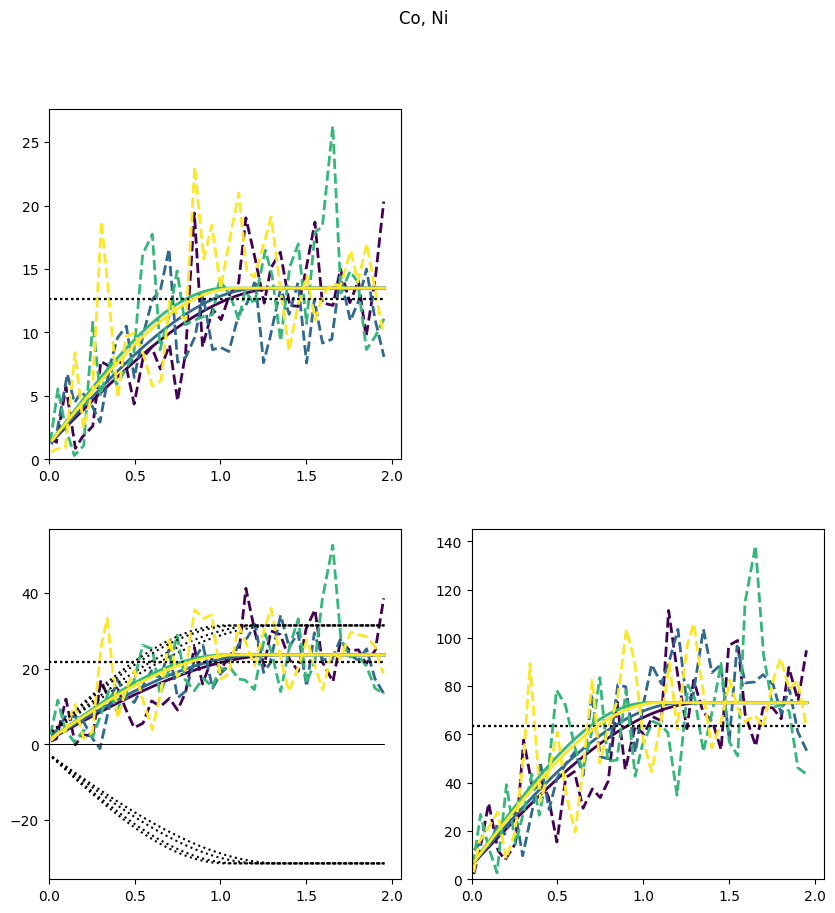

In [170]:
## Fit model on experimental cross-variograms
fitmod2var = gl.Model()
err = fitmod2var.fit(varioexp2var,
                     types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL])

## Plot
ax = gp.varmod(varioexp2var, fitmod2var, lw=2)
gp.decoration(ax,title="Co, Ni")

### IV.2 Prediction

1. Interpolate *Co* on the grid using Ordinary Cokriging and plot the resulting map as well as the standard deviation map.
2. Implement the universal cokriging.



In [171]:
## Copy the covariance model previously fitted on the data 
model_COK=gl.Model(fitmod2var)
## Add universality condition
model_COK.addDrift(gl.DriftM())

## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["COK*"])

## Compute cokriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=fitmod2var, 
                neigh=uniqueNeigh,
                namconv=gl.NamingConvention.create(prefix="COK"))

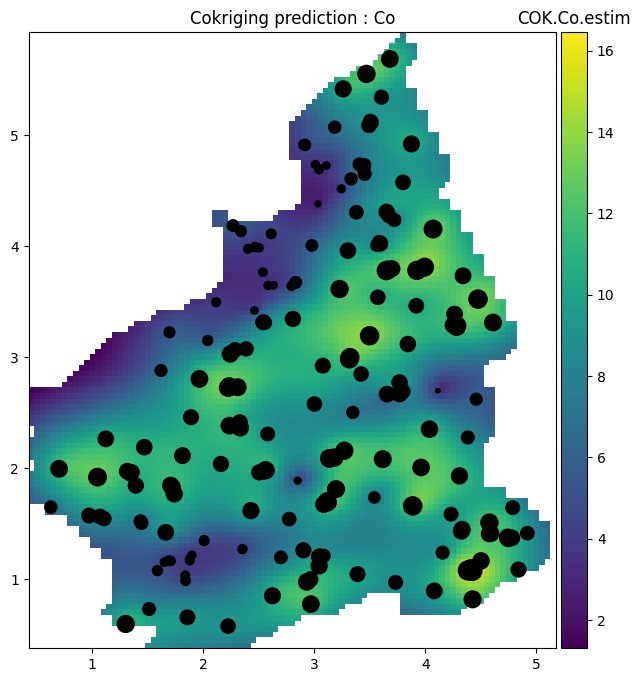

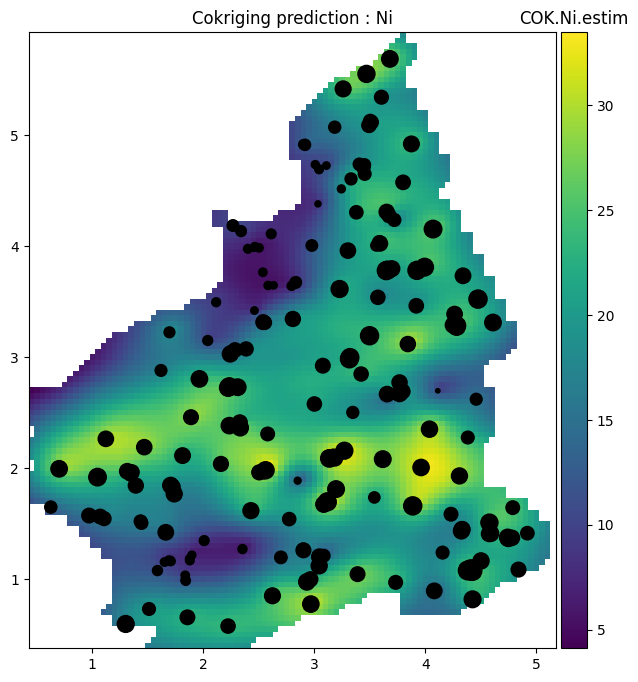

In [172]:
## Plot predictions
for metal_name in ['Co','Ni']:
    fig, ax = gp.initGeographic()
    ax.raster(db_grid, name="COK."+metal_name+".estim",flagLegend=True)
    ax.symbol(db_jura, c='black')
    ax.decoration(title="Cokriging prediction : " +metal_name)
    plt.show()

In [173]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["COK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=fitmod2var, 
                neigh=uniqueNeigh,
                namconv=gl.NamingConvention.create(prefix="COK"))

## Compute RMSE
rmse_COK=np.mean((db_val["Co"]-db_val["COK.Co.estim"])**2)
print("MSE for Cokriging on Co and Ni =",rmse_COK)

MSE for Cokriging on Co and Ni = 3.6824112480033193


## V. Maximum Likelihood estimation

1. Compute the maximum likelihood estimator of the parameters of (some of) your favorite univariate model(s) for the Cobalt concentration. 
2. Compare the models through a likelihood ratio test or by computing the AIC if they are not nested.
3. Compute the predictions each model.

We use the covariance model we computed in the last section with Co and Ni.

We then evaluate the covariance matrix, and define the likelihood function.

In [174]:
## Create databse
db_jura=gl.Db_fromPanda(jura)
## Set locators
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X)
db_jura.setLocators(['Co'],gl.ELoc.Z)

## Create DbGrid that covers the Db containing the data
db_grid=gl.DbGrid.createCoveringDb(db_jura,dx=[0.05,0.05],margin=[0.2,0.2])

## Create Db for validation set
db_val=gl.Db_fromPanda(val_loc)
## Set locators
db_val.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
## Add Co values
db_val["Co"]=val

In [175]:
varioParamOmni = gl.VarioParam.createOmniDirection(npas=30, dpas=0.1, toldis=0.5)
vario = gl.Vario.computeFromDb(varioParamOmni,db_jura)
fitmod = gl.Model()
err = fitmod.fit(vario)
modelMLE


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =     14.584
- Range        =      0.380
Total Sill     =     14.584
Known Mean(s)     0.000

In [176]:
covmat = fitmod.evalCovMatrix(db_val).toTL()

In [177]:
def neg2logLikelihood(db,model,sigma,theta,beta = 0.,F=None):
    ndat = db.getSampleNumber()
    if F is None:
        F = np.ones(shape=(db.getSampleNumber(),1)) #Vector of 1 for the mean parameter
    
    model.getCova(0).setRangeIsotropic(theta) #Fix range of the covariance model
    model.getCova(0).setSill(sigma**2) #Sill
    z = db.getColumnByLocator(gl.ELoc.Z) #Get variable Z
    betavect = np.atleast_1d(beta) # make beta a vector (in case where a single value is given)
    C = model.evalCovMatrix(db).toTL() #Covariance matrix
    F = np.ones(shape=(db.getSampleNumber(),1))

    logdet = np.linalg.slogdet(C)[1] # log determinant
    Zc = z-F@betavect #Centered bvector
    Cm1Zc = np.linalg.solve(C,Zc)
    quad = Zc.T@Cm1Zc #Quadratic term
    return logdet + quad

In [178]:
def neg2logLikelihoodForOptim(params,db,model,X=None):
    sigma = params[0]
    theta = params[1]
    beta = params[2:]  
    result = neg2logLikelihood(db,model,sigma,theta,beta,X)
    print("sill " +        str(np.round(sigma**2,2)) + 
          " range " +      str(np.round(theta,2)) +
          " mean " +       str(np.round(beta,2)) + 
          " likelihood " + str(np.round(result,2)))
    return result

def fitMLE(params,db,model,X = None):
    bds = ((0.00001,10),(0.00001,10)) + tuple((None, None) for _ in range(len(params)-2))
    return sc.optimize.minimize(neg2logLikelihoodForOptim,params,
                                args = (db,model,X),
                                bounds= bds)

In [179]:
modelMLE = fitmod.clone()
result = fitMLE(np.array([3,0.5,10]),db_jura,modelMLE)

sill 9.0 range 0.5 mean [10.] likelihood 633.23
sill 9.0 range 0.5 mean [10.] likelihood 633.23
sill 9.0 range 0.5 mean [10.] likelihood 633.23
sill 9.0 range 0.5 mean [10.] likelihood 633.23
sill 13.67 range 0.45 mean [9.28] likelihood 582.46
sill 13.67 range 0.45 mean [9.28] likelihood 582.46
sill 13.67 range 0.45 mean [9.28] likelihood 582.46
sill 13.67 range 0.45 mean [9.28] likelihood 582.46
sill 14.14 range 0.42 mean [9.23] likelihood 580.48
sill 14.14 range 0.42 mean [9.23] likelihood 580.48
sill 14.14 range 0.42 mean [9.23] likelihood 580.48
sill 14.14 range 0.42 mean [9.23] likelihood 580.48
sill 14.08 range 0.35 mean [9.27] likelihood 579.38
sill 14.08 range 0.35 mean [9.27] likelihood 579.38
sill 14.08 range 0.35 mean [9.27] likelihood 579.38
sill 14.08 range 0.35 mean [9.27] likelihood 579.38
sill 14.02 range 0.37 mean [9.29] likelihood 579.25
sill 14.02 range 0.37 mean [9.29] likelihood 579.25
sill 14.02 range 0.37 mean [9.29] likelihood 579.25
sill 14.02 range 0.37 mean [

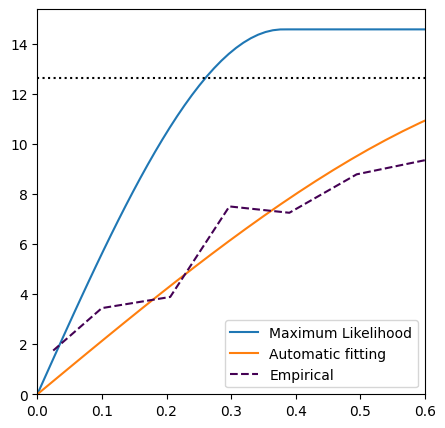

In [180]:
# plot variogram
gp.plot(modelMLE,label="Maximum Likelihood")
gp.plot(fitmod,label="Automatic fitting")
gp.plot(vario,label="Empirical")
plt.xlim([0,0.6])
aa=plt.legend()

In [181]:
modelMLE.setMean(result.x[2])
gl.kriging(db_jura,db_val,modelMLE,
           gl.NeighUnique(),namconv=gl.NamingConvention("MLE"))
krigingMLE = db_val["MLE*estim"]

In [182]:
print("MSE with MLE " + str(np.mean((krigingMLE-db_val["Co"])**2)))

MSE with MLE 4.10627855213274


## VI. Conditional simulations

The information threshold for the concentration of cobalt in soils is *12 mg/kg*. 

1. Generate 100 conditional simulations of the Cobalt concentrations over the swiss Jura according to your favorite model. 
2. Compute the mean surface of the area of exceedance as well as its associated centered 95% confidence interval.
3. Compute and plot the exceedance probability map. Comment.

In [183]:
# Step 2: Setup conditional simulations
db_grid.deleteColumns(["Simu*"])
gl.simtub(db_jura,db_grid,modelMLE,
          nbsimu=100,
          nbtuba=1000, neigh = gl.NeighUnique())

0

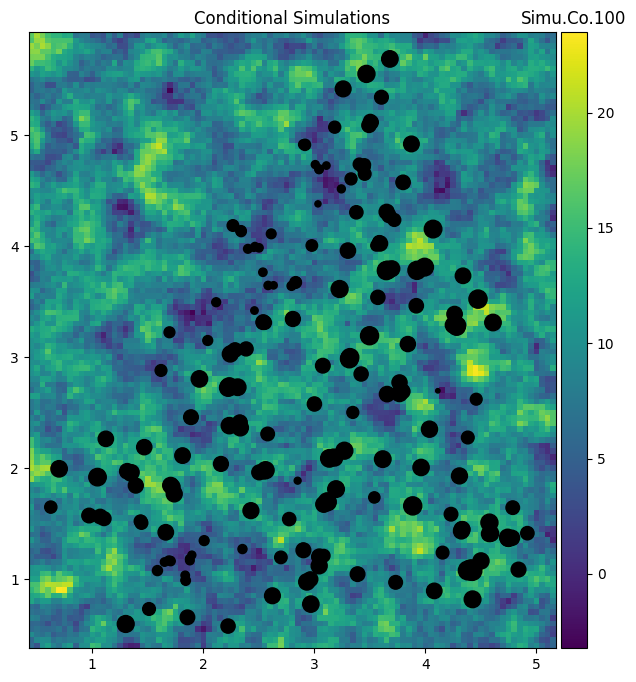

In [184]:
# show one of the simulations result
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="Simu.Co.100",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Conditional Simulations")
plt.show()

In [185]:
db_grid.statisticsBySample(names=["Simu.Co*"], opers=[gl.EStatOption.MEAN])
db_grid.statisticsBySample(names=["Simu.Co*"], opers=[gl.EStatOption.QUANT])

In [186]:
## Compute MLE
err = gl.kriging(db_jura, db_grid, model=modelMLE, 
              neigh = gl.NeighUnique(),
              namconv=gl.NamingConvention("MLE"))

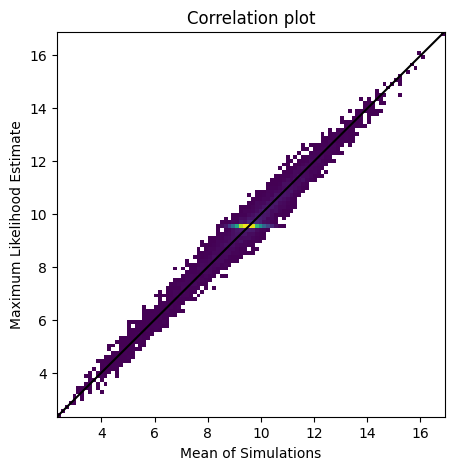

In [187]:
ax = gp.correlation(db_grid, namex="Stats.MEAN", namey="MLE*estim", diagLine=True, bins=100, cmin=1)
ax.decoration(xlabel="Mean of Simulations", ylabel="Maximum Likelihood Estimate",
             title="Correlation plot")

In [188]:
## Turn simulation results into binary variable
db_grid["Simu.Co*"] = db_grid["Simu.Co*"] > 0

## Average binary variables
db_grid.statisticsBySample(names=["Simu.Co*"], opers=[gl.EStatOption.MEAN],
                        namconv=gl.NamingConvention("Proba"))

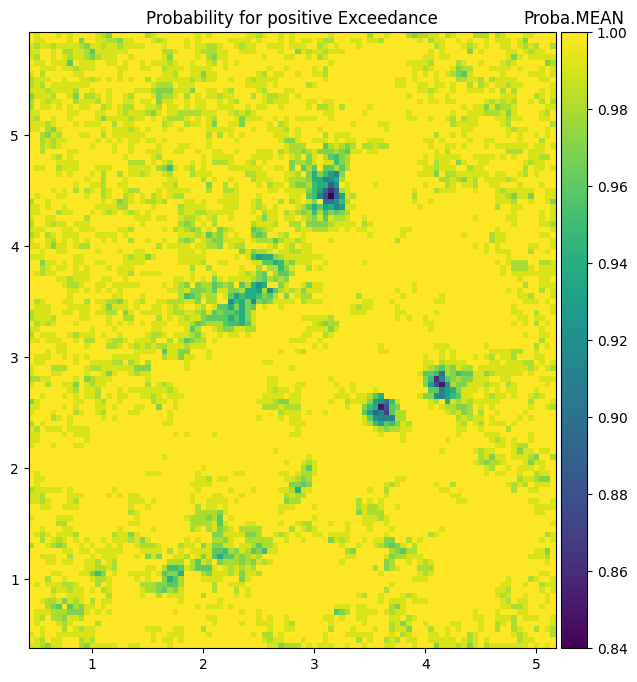

In [189]:
# Plot the results
ax = db_grid.plot("Proba.MEAN", flagLegendRaster=True)
ax.decoration(title="Probability for positive Exceedance")

#### Comment
The probability of Co concentrations exceeds the mean from 100 simulations is highlighted in yellow.

## VII. Summary -- Discussion

From all of our model, we get MSE:
- ANOVA: 8.58
- 2-Nearest Neighbour: 5.27
- Inverse distance with 3-radius: 6.18
- Random forest: 4.12
- Ordinary Kriging: 3.71
- Kriging with Drift on Rock type: 3.64
- Covariate Kriging on Co and Ni: 3.68
- Maximum Likelihood Estimation: 4.11

Overall, the best model for our validation set is Kriging with Drift on Rock type.

## Appendix: 
Description of the predictions submitted on kaggle (models, parameters) and corresponding prediction maps.


We have submissions on:
- Inverse distance with radius 3: 17.413
- Random Forest: 23.12
- Kriging with Drift on Landuse: 6.48
- Ordinal Kriging: 6.45
- ANOVA: 8.20